# Controle Continu

## Apprentissage Automaique I

### Master 2 IAAA

# Utile

---


# 1. Comparez quelques classifieurs
Et  déterminez celui qui vous semble le plus performant en généralisation en utilisant gridsearch, cross valdation et tout ce qui peut vous paraitre utile pour que cette sélection du meilleur modèle soit pertinente.

Produisez tableau de résultats, courbes de performance... et ce que vous trouvez pertinent pour justifier le modèle selectionné.


In [71]:
import numpy as np
import math
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [75]:
X_train = np.load("X_train.npy")
X_test = np.load("X_test.npy")
y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")

print (X_train.shape, X_test.shape,y_train.shape, y_test.shape)

(500, 20) (4500, 20) (500, 1) (4500, 1)


Nous pouvons effectué plusieurs train_test_split sur les données train et utilisé le test fournis pour faire de la généralisation

In [76]:
svm = SVC()
knn = KNeighborsClassifier()
tree = DecisionTreeClassifier()

In [81]:
def run(X, y, clf, k=10):
    scores = []
    for _ in range(k):
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=True, test_size=0.3)
        clf.fit(X_train, y_train)
        output = clf.predict(X_test)
        scores.append(accuracy_score(y_test, output))
    return scores

Text(0.5, 1.0, 'Comparaison de classifieurs')

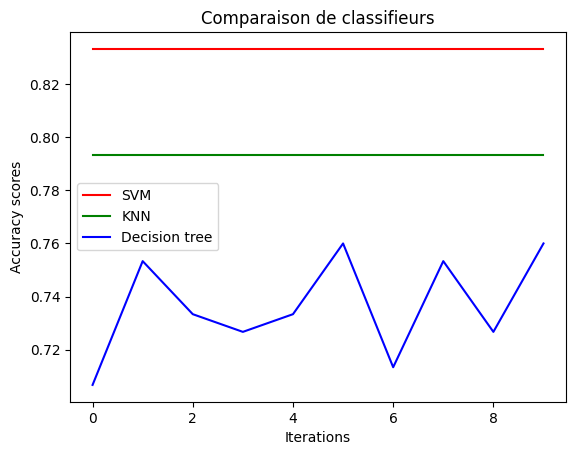

In [84]:
plt.plot(run(X_train, y_train, svm), label="SVM", c="red")
plt.plot(run(X_train, y_train, knn), label="KNN", c="green")
plt.plot(run(X_train, y_train, tree), label="Decision tree", c="blue")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Accuracy scores")
plt.title("Comparaison de classifieurs")

SVM semble être le meilleur, faisons un gridSearch pour connaitre les meilleurs hyperparamètres

In [85]:
svm_params = {"kernel": ('linear', 'rbf'), 'C': [1e-1, 1e-2, 1, 10]}
knn_params = {"n_neighbors": range(1, 10)}
tree_params = {"max_depth": range(1, 10), "criterion": ("gini", "entropy", "log_loss")}

svm = SVC()
knn = KNeighborsClassifier()
tree = DecisionTreeClassifier()
kf = KFold(n_splits=5)

In [86]:
def compute_score(clf, params, X_train, y_train, X_test, y_test, cv):
    clf = GridSearchCV(clf, params, cv=cv)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"{accuracy_score(y_test, y_pred):.2f}, Best params: {clf.best_estimator_}")
    return accuracy_score(y_test, y_pred)

In [87]:
svm_scores = compute_score(svm, svm_params, X_train, y_train, X_test, y_test, cv=kf)
knn_scores = compute_score(knn, knn_params, X_train, y_train, X_test, y_test, cv=kf)
tree_scores = compute_score(tree, tree_params, X_train, y_train, X_test, y_test, cv=kf)

0.83, Best params: SVC(C=0.1, kernel='linear')
0.77, Best params: KNeighborsClassifier(n_neighbors=7)
0.71, Best params: DecisionTreeClassifier(criterion='entropy', max_depth=7)


In [88]:
# interval 95%
def estimator(score: float, nb_example: int) -> float:
    return 1.96 *math.sqrt(score * (1 - score) * nb_example)

In [89]:
print(f"SVM: {estimator(score=0.98, nb_example=X_test.shape[0])}, \n"
      f"KNN: {estimator(score=0.8, nb_example=X_test.shape[0])}, \n"
      f"Tree: {estimator(score=0.96, nb_example=X_test.shape[0])} \n")

SVM: 18.407311590778278, 
KNN: 52.59231883079505, 
Tree: 25.764869105043026 



Le meilleur model est SVM avec un estimateur de déicision à 18

# 2. Elimination de variables inutiles

On vous apprend que 3 variables dans les données (= 3 colonnes de $X$) sont en réalité du bruit et ne contiennent aucune information sur la cible $y$.   

* Question 1)

Pourquoi ces variables de bruit sont-elles un problème ?

* Question 2)

Pour prendre en compte cette information, on vous propose de tester la procdure suivante.

2. Itérer 3 fois
* Apprendre le classifier avec l'ensemble des variables de $X$ et notez le loss obtenu en généralisation (sur une base de validation)
* Pour chacune variable $i$ des données $X$
  *   Apprenez un classifieur et testez sa performance en généralisation en utilisant toutes les variables sauf la $i^{ème}$ variable
  *   Determinez quelle variabe $i^*$ induit le moins de perte dans le loss en généralisation, c'est sans doute une variable de bruit. Vous allez la supprimer.
  * Redéfinissez les données $X$ (en train et en test) en éliminant la variable $i^*$ (vous éliminez la colonne correspondante de la matrice $X_{train}$ et la matrice $X_{test}$)

Implémentez cette stratégie, reportez les résultats obtenus de façon synthétque (tableau, grahique) et identifiez les 3 variables de bruit (donnez les indices des variables trouvées)


# Question 1°)
Ces variables sont un problème car on elles vont rendre la tâche de classification difficile pour le model.
De plus, cela augmente la dimension des données en entrés ce qui rend le calcul beaucoup plus long.


# Question 2°)

In [65]:
variables_remaining = list(range(X_train.shape[1]))
variables_removed = []

X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

In [90]:
for _ in range(3):
    clf = SVC(kernel="linear", C=0.1)
    clf.fit(X_train_copy, y_train)
    output = clf.predict(X_test_copy)

    all_loss = []
    for index in range(len(variables_remaining)):
        X_train_temp = np.delete(X_train_copy, index, axis=1)
        X_test_temp = np.delete(X_test_copy, index, axis=1)

        clf_temp = SVC(kernel="linear", C=0.1)
        clf_temp.fit(X_train_temp, y_train)
        y_pred_temp = clf_temp.predict(X_test_temp)
        loss_temp = 1 - accuracy_score(y_test, y_pred_temp)

        all_loss.append(loss_temp)
        v = variables_remaining[index]
        print(f"Variable {v}: Loss = {loss_temp:.4f}")

    min_loss_idx = all_loss.index(min(all_loss))
    variable_remove = variables_remaining[min_loss_idx]
    print(f"Variable à supprimer: {variable_remove}, Loss: {min(all_loss):.4f}")
    X_train_current = np.delete(X_train_copy, min_loss_idx, axis=1)
    X_test_current = np.delete(X_test_copy, min_loss_idx, axis=1)
    variables_removed.append(variable_remove)
    del variables_remaining[min_loss_idx]

print(f"Variable supprimer: {variables_removed}")


Variable 0: Loss = 0.1756
Variable 1: Loss = 0.1667
Variable 2: Loss = 0.1736
Variable 3: Loss = 0.1707
Variable 4: Loss = 0.1724
Variable 5: Loss = 0.1880
Variable 6: Loss = 0.1760
Variable 7: Loss = 0.1736
Variable 8: Loss = 0.1680
Variable 9: Loss = 0.1698
Variable 10: Loss = 0.1751
Variable 11: Loss = 0.1698
Variable 12: Loss = 0.1669
Variable 13: Loss = 0.1736
Variable 14: Loss = 0.1702
Variable 18: Loss = 0.1662
Variable 19: Loss = 0.1753
Variable à supprimer: 18, Loss: 0.1662
Variable 0: Loss = 0.1756
Variable 1: Loss = 0.1667
Variable 2: Loss = 0.1736
Variable 3: Loss = 0.1707
Variable 4: Loss = 0.1724
Variable 5: Loss = 0.1880
Variable 6: Loss = 0.1760
Variable 7: Loss = 0.1736
Variable 8: Loss = 0.1680
Variable 9: Loss = 0.1698
Variable 10: Loss = 0.1751
Variable 11: Loss = 0.1698
Variable 12: Loss = 0.1669
Variable 13: Loss = 0.1736
Variable 14: Loss = 0.1702
Variable 19: Loss = 0.1662
Variable à supprimer: 19, Loss: 0.1662
Variable 0: Loss = 0.1756
Variable 1: Loss = 0.1667